In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import time
from sklearn.metrics import f1_score, classification_report, precision_recall_fscore_support, confusion_matrix

In [2]:
def preprocess_data(data_path):
    data = pd.read_csv(data_path)
    data['label'] = data['Suicide'].map({'suicide': 1, 'non-suicide': 0})
    data = data.dropna(subset=['Tweet', 'label'])
    # Enhanced preprocessing
    data['Tweet'] = data['Tweet'].str.lower()
    data['Tweet'] = data['Tweet'].str.replace(r'http\S+|www.\S+', '', regex=True)  # Remove URLs
    data['Tweet'] = data['Tweet'].str.replace(r'@\w+', '@user', regex=True)  # Standardize mentions
    data['Tweet'] = data['Tweet'].str.replace(r'[^\w\s]', '', regex=True)  # Remove special characters
    return data

In [3]:
# Dataset class with proper padding
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, tokenizer, MAX_LENGTH = 512):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.tokenizer = tokenizer
        self.max_length = MAX_LENGTH
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        tokens = self.tokenizer(self.texts.iloc[idx])
        indices = [self.vocab[token] for token in tokens]
        
        # Padding/truncating
        if len(indices) < self.max_length:
            indices = indices + [self.vocab['<pad>']] * (self.max_length - len(indices))
        else:
            indices = indices[:self.max_length]
            
        return torch.tensor(indices, dtype=torch.long), torch.tensor(self.labels.iloc[idx], dtype=torch.long)

In [4]:
# Enhanced model with LSTM
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers=2, dropout=0.5):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=1)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, 
                           batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 for bidirectional
        
    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        hidden = self.dropout(hidden)
        return self.fc(hidden)

In [5]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)       
            total_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    val_f1 = f1_score(val_labels, val_preds, average='binary')
    val_report = classification_report(val_labels, val_preds, digits=4)
    return total_loss / len(dataloader), correct / total, val_f1, val_report

In [6]:
def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, 
                device, num_epochs=25, patience=3):
    best_val_loss = float('inf')
    patience_counter = 0
    train_acc_hist = []
    train_loss_hist = []
    val_loss_hist = []
    val_acc_hist = []
    train_f1_hist = []
    val_f1_hist = []
    for epoch in range(num_epochs):
        # Training
        start_time = time.time()
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        
        for texts, labels in train_dataloader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        train_loss = total_loss / len(train_dataloader)
        train_acc = correct / total
        train_f1 = f1_score(all_labels, all_preds, average='binary')
        train_report = classification_report(all_labels, all_preds, digits=4)
        # Validation
        val_loss, val_acc, val_f1, val_report = evaluate(model, val_dataloader, criterion, device)
        # Calculate time elapsed
        epoch_time = time.time() - start_time
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
        print(f'Train F1: {train_f1}')
        print('Train classification Report:')
        print(train_report)
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
        print(f'Val F1: {val_f1}')
        print('Val classification Report:')
        print(val_report)
        print(f'Time Elapsed: {epoch_time:.2f} seconds')
        train_acc_hist.append(train_acc)
        train_loss_hist.append(train_loss)
        train_f1_hist.append(train_f1)
        val_acc_hist.append(val_acc)
        val_loss_hist.append(val_loss)
        val_f1_hist.append(val_f1)
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping triggered')
                return epoch, train_acc_hist, train_loss_hist, val_acc_hist, val_loss_hist, train_f1_hist, val_f1_hist
                break
    return epoch, train_acc_hist, train_loss_hist, val_acc_hist, val_loss_hist, train_f1_hist, val_f1_hist


In [7]:
EMBED_DIM = 256
HIDDEN_DIM = 128
BATCH_SIZE = 1024
LEARNING_RATE = 1e-4
MAX_LENGTH = 512

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
data = preprocess_data('Suicide_Detection.csv')
data.head()

,Tweet,Suicide,label
0,ex wife threatening suiciderecently i left my ...,suicide,1
1,am i weird i dont get affected by compliments ...,non-suicide,0
2,finally 2020 is almost over so i can never hea...,non-suicide,0
3,i need helpjust help me im crying so hard,suicide,1
4,im so losthello my name is adam 16 and ive bee...,suicide,1


In [10]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
        data['Tweet'], data['label'], test_size=0.2, random_state=42, stratify=data['label']
    )

In [11]:
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(
        map(tokenizer, train_texts),
        specials=['<unk>', '<pad>'],
        min_freq=2)
vocab.set_default_index(vocab['<unk>'])

In [12]:
train_dataset = TextDataset(train_texts, train_labels, vocab, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, vocab, tokenizer)

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [14]:
model = TextClassificationModel(
    vocab_size=len(vocab),
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_classes=2
).to(device)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Train model
epoch, train_acc_hist, train_loss_hist, val_acc_hist, val_loss_hist, train_f1_hist, val_f1_hist = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, device)

Epoch 1/25:
Train Loss: 0.5286 | Train Acc: 0.7281
Train F1: 0.7333062125879002
Train classification Report:
              precision    recall  f1-score   support

           0     0.7374    0.7086    0.7227     92829
           1     0.7196    0.7476    0.7333     92830

    accuracy                         0.7281    185659
   macro avg     0.7285    0.7281    0.7280    185659
weighted avg     0.7285    0.7281    0.7280    185659

Val Loss: 0.3460 | Val Acc: 0.8621
Val F1: 0.8602737333828119
Val classification Report:
              precision    recall  f1-score   support

           0     0.8529    0.8751    0.8639     23208
           1     0.8717    0.8491    0.8603     23207

    accuracy                         0.8621     46415
   macro avg     0.8623    0.8621    0.8621     46415
weighted avg     0.8623    0.8621    0.8621     46415

Time Elapsed: 114.23 seconds
Epoch 2/25:
Train Loss: 0.3179 | Train Acc: 0.8764
Train F1: 0.8737810679851941
Train classification Report:
          

In [22]:
print(f"Train acc: {train_acc_hist}")
print(f"Train loss: {train_loss_hist}")
print(f"Train F1-score: {train_f1_hist}")
print(f"Val acc: {val_acc_hist}")
print(f"Val loss: {val_loss_hist}")
print(f"Val F1-score: {val_f1_hist}")

Train acc: [0.728109060158678, 0.8763916642877534, 0.8956473965711331, 0.9110842997107601, 0.9202193268303718, 0.9262088021587965, 0.9322521396754264, 0.9366203631388729, 0.9403637852191383, 0.9425613624979129, 0.9465363919874609, 0.9489009420496717, 0.9506676218228042, 0.9535761799858881, 0.9547988516581475, 0.9568079112782036, 0.9595441104390307, 0.9610684103652395, 0.9631313321735009, 0.9645479077232991, 0.9657598069579175]
Train loss: [0.5286193920688315, 0.3178891604254534, 0.27136590012482237, 0.23376332370789496, 0.21059316462212865, 0.19605699754678285, 0.18295487401249644, 0.1720201211807492, 0.16367701371456242, 0.156305771116372, 0.14688261467349398, 0.14008165662596514, 0.13595744365682969, 0.12830298013248287, 0.12488877756910009, 0.11980814249305935, 0.11322397955662601, 0.10957635026220437, 0.10384455802185195, 0.09816446601525768, 0.09716153181679957]
Train F1-score: [0.7333062125879002, 0.8737810679851941, 0.89344054913263, 0.9097262476348802, 0.9194579780755177, 0.925

In [17]:
epochs = range(1, len(train_loss_hist) + 1)

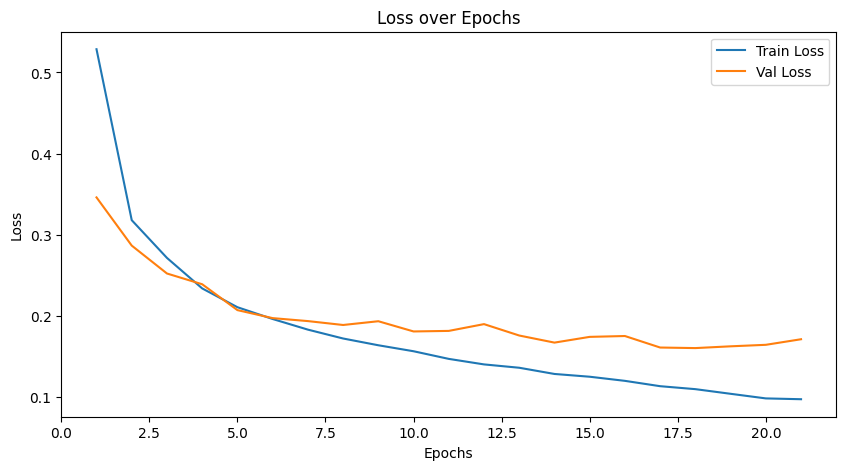

In [18]:
# Loss Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_hist, label='Train Loss')
plt.plot(epochs, val_loss_hist, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

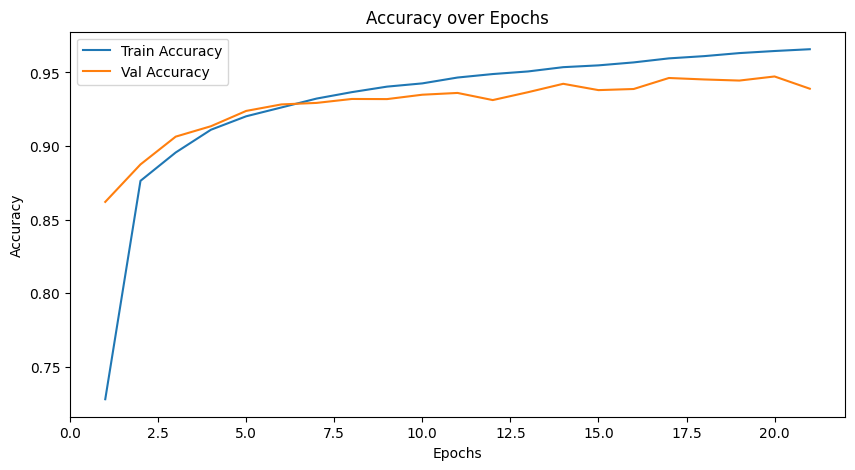

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc_hist, label='Train Accuracy')
plt.plot(epochs, val_acc_hist, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

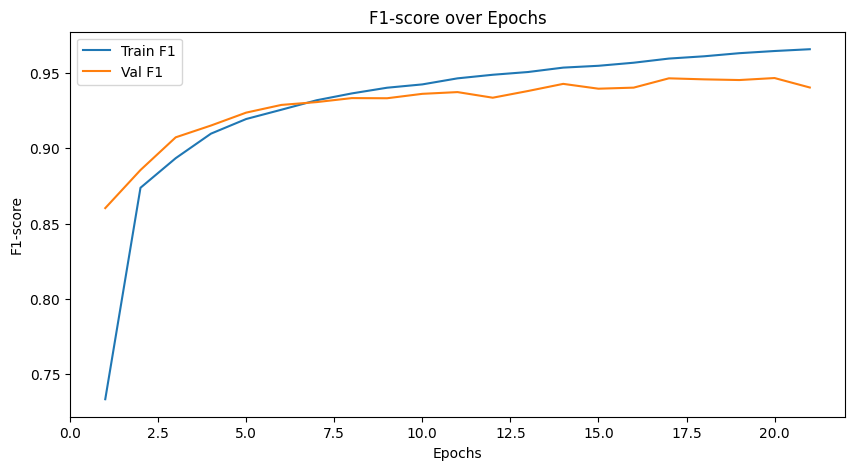

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_f1_hist, label='Train F1')
plt.plot(epochs, val_f1_hist, label='Val F1')
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.title('F1-score over Epochs')
plt.legend()
plt.show()